# Transformers for Univariate Financial Time Series Forecasting: A Step-by-Step Guide

## 🎯 Learning Objectives

By the end of this notebook, you will understand:

1. **Transformer Architecture**: How transformers work for time series forecasting (vs. traditional NLP applications)
2. **Self-Attention Mechanism**: How attention helps capture temporal dependencies in financial data
3. **Data Preparation**: Proper techniques for preparing time series data for transformer models
4. **Model Training**: Best practices for training transformers on sequential financial data
5. **Evaluation & Interpretation**: How to assess model performance and interpret predictions

---

## 📚 What You'll Build

We'll build a **Transformer-based forecasting model** that:
- Takes a sequence of past observations (100 time steps)
- Predicts future values (20 time steps ahead)
- Uses self-attention to capture complex temporal patterns
- Works with univariate time series (single variable)

---

## 🔍 Why Transformers for Financial Time Series?

**Traditional Approaches** (ARIMA, RNN, LSTM):
- Sequential processing (slow for long sequences)
- Struggle with long-range dependencies
- Limited parallelization

**Transformer Advantages**:
- **Parallel processing**: All time steps processed simultaneously
- **Self-attention**: Directly models relationships between any two time steps
- **Long-range dependencies**: Can capture patterns across distant time points
- **Scalability**: Efficient for long sequences

---

Let's get started!

In [1]:
%load_ext autoreload 
%autoreload 2

## 1. Setup and Imports

First, we'll configure the notebook environment and import necessary libraries.

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 1.1 Auto-reload Extension
This ensures that any changes to imported modules are automatically reloaded.

In [3]:
import sys
sys.path.append('../../')

In [4]:
import numpy as np
import pandas as pd

### 1.2 Core Libraries
- **NumPy**: Numerical computations
- **Pandas**: Data manipulation
- **PyTorch**: Deep learning framework

In [5]:
import torch

In [6]:
from torch.utils.data import Dataset, DataLoader


In [7]:
from dlf.models.transformer.transformer import TimeSeriesTransformer
from dlf.models.transformer.trainer import train_model
from dlf.models.transformer.evaluator import evaluate_model, plot_results

from dlf.models.transformer.univariate import TimeSeriesDataset,generate_synthetic_data



### 1.3 Custom Modules

We'll import our custom transformer implementation from the `dlf` package:
- **TimeSeriesTransformer**: The main transformer model architecture
- **train_model**: Training loop with loss tracking
- **evaluate_model**: Evaluation and prediction generation
- **TimeSeriesDataset**: Custom dataset for windowed time series data
- **generate_synthetic_data**: Creates realistic synthetic financial time series

---

## 2. Transformer Architecture for Time Series: Theoretical Background

### 2.1 The Self-Attention Mechanism

**Key Concept**: Instead of processing time series sequentially (like RNNs), transformers compute attention scores between ALL pairs of time steps simultaneously.

**For time series at position t:**
```
Attention(Q, K, V) = softmax(QK^T / √d_k) × V
```

Where:
- **Q (Query)**: "What am I looking for?" - Current time step asking questions
- **K (Key)**: "What do I have?" - All time steps offering information  
- **V (Value)**: "What information do I provide?" - Actual values to aggregate
- **d_k**: Dimension of keys (scaling factor)

**Financial Interpretation**:
- High attention scores mean "this past time step is relevant for predicting the current value"
- The model learns which historical patterns matter for forecasting
- Example: A stock price spike 50 days ago might be relevant for today's prediction

### 2.2 Positional Encoding

**Problem**: Transformers process all positions in parallel → no inherent notion of sequence order

**Solution**: Add positional encodings to embed temporal order information

```
PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
```

This ensures the model knows that day t=10 comes before day t=11.

### 2.3 Architecture Components

1. **Input Embedding**: Projects input features to d_model dimensions
2. **Positional Encoding**: Adds temporal position information
3. **Encoder Layers**: Stack of self-attention + feed-forward networks
4. **Output Projection**: Maps back to prediction dimension

---

In [8]:
# Hyperparameters
seq_length = 100  # Input sequence length (lookback window)
pred_length = 20  # Prediction length (forecast horizon)
d_model = 64      # Model dimension (embedding size)
nhead = 8         # Number of attention heads
num_layers = 4    # Number of transformer encoder layers
batch_size = 32   # Training batch size
epochs = 80       # Number of training epochs
learning_rate = 0.001  # Learning rate for Adam optimizer

print("Generating synthetic time series data...")
data = generate_synthetic_data(length=2000, noise_level=0.1)

Generating synthetic time series data...


## 3. Data Generation and Exploration

### 3.1 Hyperparameters Configuration

Let's define our model and data parameters:

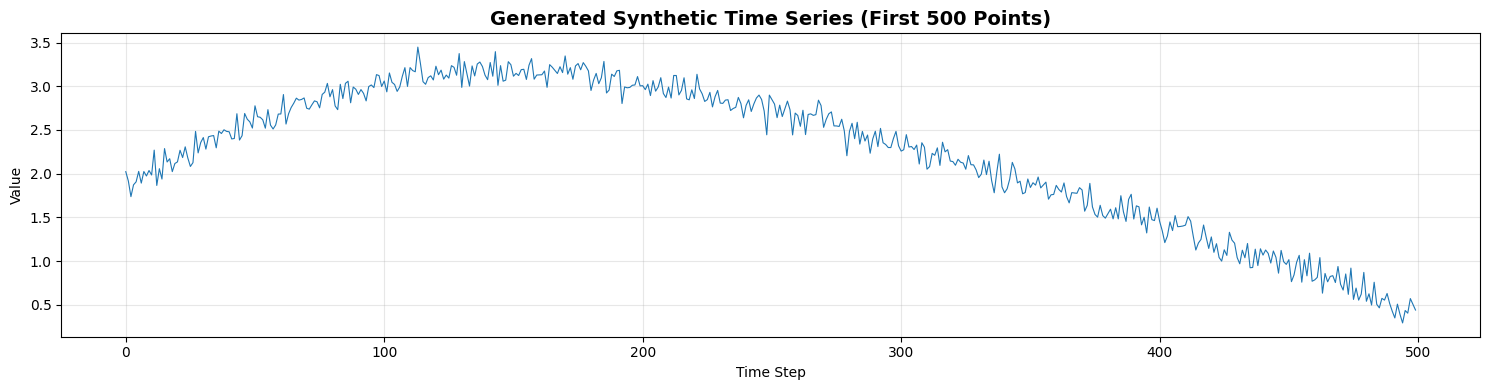

Data shape: (2000,)
Data range: [-3.764, 3.448]
Data mean: 0.064
Data std: 1.794


In [9]:
import matplotlib.pyplot as plt

# Visualize the generated data
plt.figure(figsize=(15, 4))
plt.plot(data[:500], linewidth=0.8)
plt.title('Generated Synthetic Time Series (First 500 Points)', fontsize=14, fontweight='bold')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Data shape: {data.shape}")
print(f"Data range: [{data.min():.3f}, {data.max():.3f}]")
print(f"Data mean: {data.mean():.3f}")
print(f"Data std: {data.std():.3f}")

### 3.2 Understanding the Hyperparameters

**Data Parameters:**
- `seq_length = 100`: We use 100 past observations to make predictions
  - Like looking at 100 days of stock prices to predict the next 20 days
  - Longer sequences capture more historical context but require more computation
  
- `pred_length = 20`: We forecast 20 time steps into the future
  - Multi-step ahead forecasting
  - More challenging than 1-step ahead prediction

**Model Architecture:**
- `d_model = 64`: Embedding dimension
  - Each time step is represented as a 64-dimensional vector
  - Higher values = more expressive but more parameters
  
- `nhead = 8`: Number of attention heads
  - Multi-head attention allows the model to attend to different aspects simultaneously
  - Head 1 might focus on short-term patterns, Head 2 on long-term trends, etc.
  - Must divide evenly into d_model (64/8 = 8 dimensions per head)
  
- `num_layers = 4`: Depth of the transformer
  - Each layer refines the representations
  - Deeper models capture more complex patterns but risk overfitting

**Training:**
- `batch_size = 32`: Process 32 sequences per gradient update
- `epochs = 80`: Complete passes through the training data
- `learning_rate = 0.001`: Standard Adam optimizer learning rate

Let's examine the generated data:

### 3.3 Alternative: Real Financial Data

The commented code below shows how to use real financial data (e.g., QQQ ETF returns) instead of synthetic data.

**Why start with synthetic data?**
- Controlled environment for learning
- Known patterns to verify model is working
- No external dependencies (API keys, data files)

**For real applications**, uncomment and adapt the code below:

In [10]:
# data = np.array(df['prior_1D_return'].dropna())

In [11]:
data

array([2.02301215, 1.91593041, 1.73726295, ..., 1.93552586, 1.88555854,
       2.12143346])

In [12]:
len(data)

2000

In [13]:
# data = np.array(df['prior_1D_return'].tail(2000))

In [14]:
data

array([2.02301215, 1.91593041, 1.73726295, ..., 1.93552586, 1.88555854,
       2.12143346])

In [15]:
len(data)

2000

---

## 4. Data Preprocessing

### 4.1 Train-Validation-Test Split

**Critical for time series**: We MUST respect temporal order!

- **Train set**: 70% (first portion) - Learn patterns
- **Validation set**: 15% (middle portion) - Tune hyperparameters, prevent overfitting  
- **Test set**: 15% (last portion) - Final evaluation on unseen future data

**Why not random split?**
- Time series have temporal dependencies
- Random splitting would leak future information into the past
- We want to simulate real forecasting: predict the future using only past data

Total data points: 2000
Train: 1400 points (indices 0-1399)
Validation: 300 points (indices 1400-1699)
Test: 300 points (indices 1700-1999)


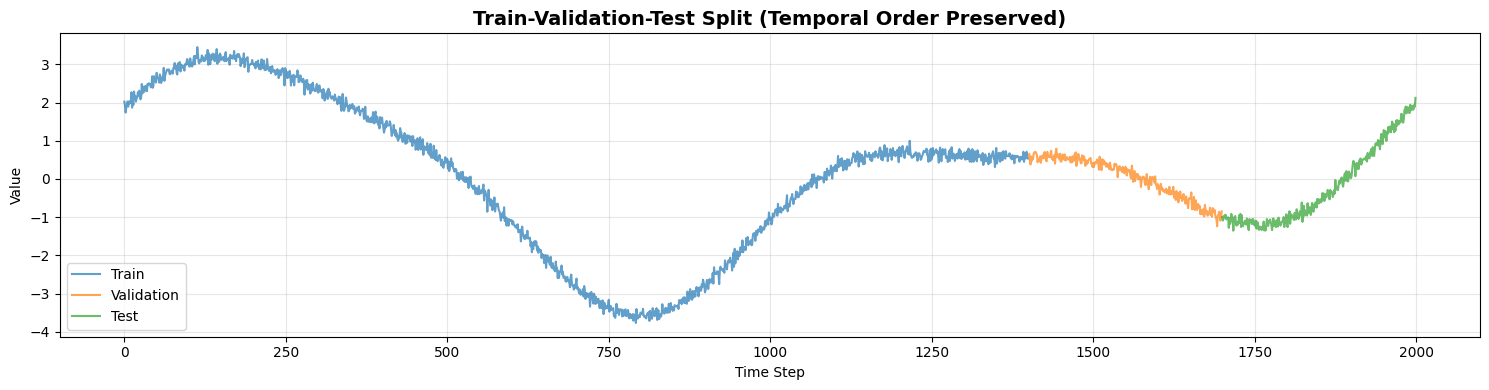

In [16]:
# Split data chronologically
train_size = int(0.7 * len(data))  # 70% for training
val_size = int(0.15 * len(data))   # 15% for validation

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

print(f"Total data points: {len(data)}")
print(f"Train: {len(train_data)} points (indices 0-{train_size-1})")
print(f"Validation: {len(val_data)} points (indices {train_size}-{train_size+val_size-1})")
print(f"Test: {len(test_data)} points (indices {train_size+val_size}-{len(data)-1})")

# Visualize the split
plt.figure(figsize=(15, 4))
plt.plot(range(len(train_data)), train_data, label='Train', alpha=0.7)
plt.plot(range(len(train_data), len(train_data) + len(val_data)), val_data, label='Validation', alpha=0.7)
plt.plot(range(len(train_data) + len(val_data), len(data)), test_data, label='Test', alpha=0.7)
plt.title('Train-Validation-Test Split (Temporal Order Preserved)', fontsize=14, fontweight='bold')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# Normalize using ONLY training data statistics
mean = np.mean(train_data)
std = np.std(train_data)

print(f"Training data statistics:")
print(f"  Mean: {mean:.4f}")
print(f"  Std:  {std:.4f}")

# Apply normalization to all sets
train_data_normalized = (train_data - mean) / std
val_data_normalized = (val_data - mean) / std
test_data_normalized = (test_data - mean) / std

# Verify normalization
print(f"\nAfter normalization:")
print(f"  Train - Mean: {train_data_normalized.mean():.4f}, Std: {train_data_normalized.std():.4f}")
print(f"  Val   - Mean: {val_data_normalized.mean():.4f}, Std: {val_data_normalized.std():.4f}")
print(f"  Test  - Mean: {test_data_normalized.mean():.4f}, Std: {test_data_normalized.std():.4f}")

# Update variables for consistency with rest of notebook
train_data = train_data_normalized
val_data = val_data_normalized
test_data = test_data_normalized

Training data statistics:
  Mean: 0.1265
  Std:  2.0732

After normalization:
  Train - Mean: 0.0000, Std: 1.0000
  Val   - Mean: -0.0412, Std: 0.2514
  Test  - Mean: -0.1587, Std: 0.4894


### 4.2 Normalization (Standardization)

**Why normalize?**
1. **Gradient stability**: Prevents exploding/vanishing gradients
2. **Faster convergence**: Optimization works better when features are on similar scales
3. **Attention mechanism**: Dot products in attention are sensitive to magnitude

**Method**: Z-score normalization
```
normalized_value = (value - mean) / std
```

**Critical rule**: Use ONLY training statistics!
- Compute mean and std from training data only
- Apply same transformation to validation and test sets
- This prevents data leakage (test data shouldn't influence training)

In [18]:
# Create datasets with sliding windows
train_dataset = TimeSeriesDataset(train_data, seq_length, pred_length)
val_dataset = TimeSeriesDataset(val_data, seq_length, pred_length)

# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset sizes:")
print(f"  Train: {len(train_dataset)} sequences")
print(f"  Val:   {len(val_dataset)} sequences")
print(f"\nEach sequence:")
print(f"  Input:  {seq_length} time steps")
print(f"  Target: {pred_length} time steps")
print(f"\nBatch configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")

Dataset sizes:
  Train: 1281 sequences
  Val:   181 sequences

Each sequence:
  Input:  100 time steps
  Target: 20 time steps

Batch configuration:
  Batch size: 32
  Train batches: 41
  Val batches:   6


### 4.3 Creating Windowed Datasets

**The Sliding Window Approach:**

For time series forecasting, we create overlapping sequences:

```
Data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...]

Window 1: Input=[0,1,2,3,4] → Target=[5,6,7]
Window 2: Input=[1,2,3,4,5] → Target=[6,7,8]
Window 3: Input=[2,3,4,5,6] → Target=[7,8,9]
...
```

In our case:
- **Input window**: 100 time steps (seq_length)
- **Output window**: 20 time steps (pred_length)
- **Stride**: 1 (move one step at a time)

This creates many training examples from a single time series!

In [19]:
# Get a sample batch
sample_x, sample_y = next(iter(train_loader))

print(f"Sample batch shapes:")
print(f"  Input (X):  {sample_x.shape}  → [batch_size, seq_length, features]")
print(f"  Target (Y): {sample_y.shape}  → [batch_size, pred_length, features]")
print(f"\nThis means:")
print(f"  - {sample_x.shape[0]} sequences in this batch")
print(f"  - Each sequence has {sample_x.shape[1]} input time steps")
print(f"  - Each time step has {sample_x.shape[2]} feature(s) (univariate)")
print(f"  - We predict {sample_y.shape[1]} future time steps")

Sample batch shapes:
  Input (X):  torch.Size([32, 100, 1])  → [batch_size, seq_length, features]
  Target (Y): torch.Size([32, 20, 1])  → [batch_size, pred_length, features]

This means:
  - 32 sequences in this batch
  - Each sequence has 100 input time steps
  - Each time step has 1 feature(s) (univariate)
  - We predict 20 future time steps


### 4.4 Verify Dataset Structure

Let's inspect a sample to ensure our windowing is correct:

---

## 5. Model Architecture

### 5.1 TimeSeriesTransformer Overview

Our transformer model consists of:

1. **Input Projection**: Linear layer mapping input dimension → d_model
2. **Positional Encoding**: Adds temporal position information
3. **Transformer Encoder**: Stack of self-attention + FFN layers
4. **Output Projection**: Linear layer mapping d_model → output dimension

**Key differences from NLP transformers:**
- **No decoder**: We use encoder-only architecture
- **Direct prediction**: Output projection directly generates multi-step forecasts
- **Causal attention**: (Optional) Can mask future positions during attention

### 5.2 Model Initialization

In [20]:
# Initialize the transformer model
model = TimeSeriesTransformer(
    input_dim=1,           # Univariate time series (1 feature)
    d_model=d_model,       # Embedding dimension (64)
    nhead=nhead,           # Number of attention heads (8)
    num_layers=num_layers, # Number of transformer layers (4)
    output_dim=1,          # Univariate output (1 feature)
    seq_length=seq_length, # Input sequence length (100)
    pred_length=pred_length, # Prediction horizon (20)
    dropout=0.1            # Dropout rate for regularization
)

# Count model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"\nParameter breakdown:")
print(f"  d_model: {d_model}")
print(f"  Attention heads: {nhead} × {d_model // nhead} dimensions each")
print(f"  Encoder layers: {num_layers}")
print(f"  Approx params per layer: {total_params // num_layers:,}")

print("\n" + "="*60)
print("Starting Training...")
print("="*60 + "\n")

# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs, learning_rate)

Model Architecture:
  Total parameters: 201,364
  Trainable parameters: 201,364

Parameter breakdown:
  d_model: 64
  Attention heads: 8 × 8 dimensions each
  Encoder layers: 4
  Approx params per layer: 50,341

Starting Training...

Training on device: cpu
Model parameters: 201364
Epoch   0: Train Loss = 0.143453, Val Loss = 0.009854
Epoch  10: Train Loss = 0.013956, Val Loss = 0.007617
Epoch  20: Train Loss = 0.011090, Val Loss = 0.004191
Epoch  30: Train Loss = 0.007780, Val Loss = 0.016112
Epoch  40: Train Loss = 0.005136, Val Loss = 0.007433
Epoch  50: Train Loss = 0.004940, Val Loss = 0.007712
Epoch  60: Train Loss = 0.004520, Val Loss = 0.009480
Epoch  70: Train Loss = 0.004388, Val Loss = 0.010847
Epoch  79: Train Loss = 0.004356, Val Loss = 0.010637


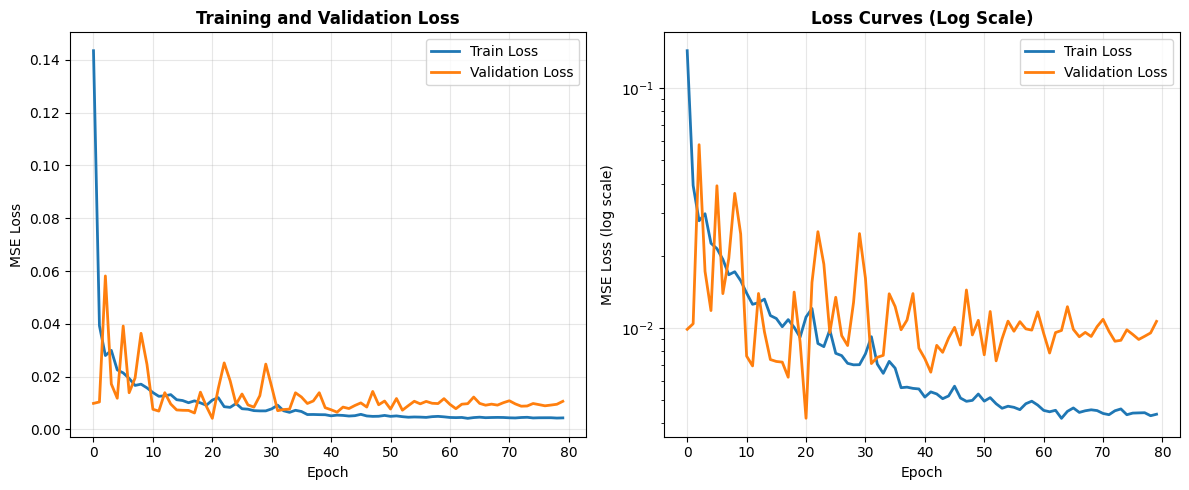


Training Summary:
  Initial train loss: 0.143453
  Final train loss:   0.004356
  Reduction:          97.0%

  Initial val loss:   0.009854
  Final val loss:     0.010637
  Best val loss:      0.004191 (epoch 20)

⚠️  Potential overfitting detected (train loss << val loss)


In [21]:
# Analyze training curves
plt.figure(figsize=(12, 5))

# Plot 1: Full training history
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Log scale for better visualization
plt.subplot(1, 2, 2)
plt.semilogy(train_losses, label='Train Loss', linewidth=2)
plt.semilogy(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.title('Loss Curves (Log Scale)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print(f"\nTraining Summary:")
print(f"  Initial train loss: {train_losses[0]:.6f}")
print(f"  Final train loss:   {train_losses[-1]:.6f}")
print(f"  Reduction:          {(1 - train_losses[-1]/train_losses[0])*100:.1f}%")
print(f"\n  Initial val loss:   {val_losses[0]:.6f}")
print(f"  Final val loss:     {val_losses[-1]:.6f}")
print(f"  Best val loss:      {min(val_losses):.6f} (epoch {np.argmin(val_losses)})")

# Check for overfitting
if train_losses[-1] < val_losses[-1] * 0.5:
    print("\n⚠️  Potential overfitting detected (train loss << val loss)")
elif val_losses[-1] < train_losses[-1] * 0.9:
    print("\n✓ Good generalization (val loss ≈ train loss)")
else:
    print("\n✓ Model converged well")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---

## 6. Training Process

### 6.1 Understanding the Training Loop

The `train_model` function performs:

1. **Forward Pass**: Input sequences → Model predictions
2. **Loss Calculation**: Compare predictions with actual future values (MSE)
3. **Backward Pass**: Compute gradients via backpropagation
4. **Optimizer Step**: Update model parameters using Adam optimizer
5. **Validation**: Evaluate on validation set (no gradient updates)

**What to watch for:**
- **Decreasing train loss**: Model is learning
- **Decreasing val loss**: Model generalizes well
- **Val loss << Train loss**: Might be underfitting (increase capacity)
- **Val loss >> Train loss**: Overfitting (add regularization, reduce capacity)

### 6.2 Training Results Interpretation

In [22]:
# Evaluate on test set
print("Evaluating model on test data...")
print("="*60)

# Generate predictions for 5 different test sequences
num_test_predictions = 5
predictions, actuals = evaluate_model(
    model, 
    test_data, 
    seq_length, 
    pred_length,
    device,  
    num_predictions=num_test_predictions
)

# Calculate metrics on normalized data
if predictions and actuals:
    # Compute errors for each prediction
    errors = [np.array(p) - np.array(a) for p, a in zip(predictions, actuals)]
    
    mse = np.mean([e**2 for e in errors])
    mae = np.mean([np.abs(e) for e in errors])
    rmse = np.sqrt(mse)
    
    print(f"\nTest Metrics (Normalized Scale):")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    
    # Denormalize for interpretability
    predictions_denorm = [(np.array(p) * std + mean) for p in predictions]
    actuals_denorm = [(np.array(a) * std + mean) for a in actuals]
    errors_denorm = [np.array(p) - np.array(a) for p, a in zip(predictions_denorm, actuals_denorm)]
    
    mse_denorm = np.mean([e**2 for e in errors_denorm])
    mae_denorm = np.mean([np.abs(e) for e in errors_denorm])
    rmse_denorm = np.sqrt(mse_denorm)
    
    print(f"\nTest Metrics (Original Scale):")
    print(f"  MSE:  {mse_denorm:.6f}")
    print(f"  RMSE: {rmse_denorm:.6f}")
    print(f"  MAE:  {mae_denorm:.6f}")
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean([np.abs(e / (a + 1e-8)) * 100 for e, a in zip(errors_denorm, actuals_denorm)])
    print(f"  MAPE: {mape:.2f}%")
    
else:
    print("⚠️  No predictions generated")
    
# Store denormalized data for visualization
# Use the same data we generated at the beginning (it's deterministic with the seed)
data_original = data * std + mean  # Denormalize the original data we already have

Evaluating model on test data...

Test Metrics (Normalized Scale):
  MSE:  0.100827
  RMSE: 0.317532
  MAE:  0.270256

Test Metrics (Original Scale):
  MSE:  0.433361
  RMSE: 0.658301
  MAE:  0.560290
  MAPE: 50.86%


---

## 7. Model Evaluation

### 7.1 Test Set Predictions

Now we evaluate on the test set - data the model has NEVER seen during training or validation.

**What we're doing:**
1. Take sequences from test data
2. Generate multi-step forecasts (20 steps ahead)
3. Compare predictions with actual values
4. Calculate error metrics

**Evaluation Metrics:**
- **MSE (Mean Squared Error)**: Average squared difference
  - Penalizes large errors heavily
  - Unit: squared units of original data
  
- **MAE (Mean Absolute Error)**: Average absolute difference
  - More robust to outliers
  - Same units as original data
  - Easier to interpret


Generating visualization...


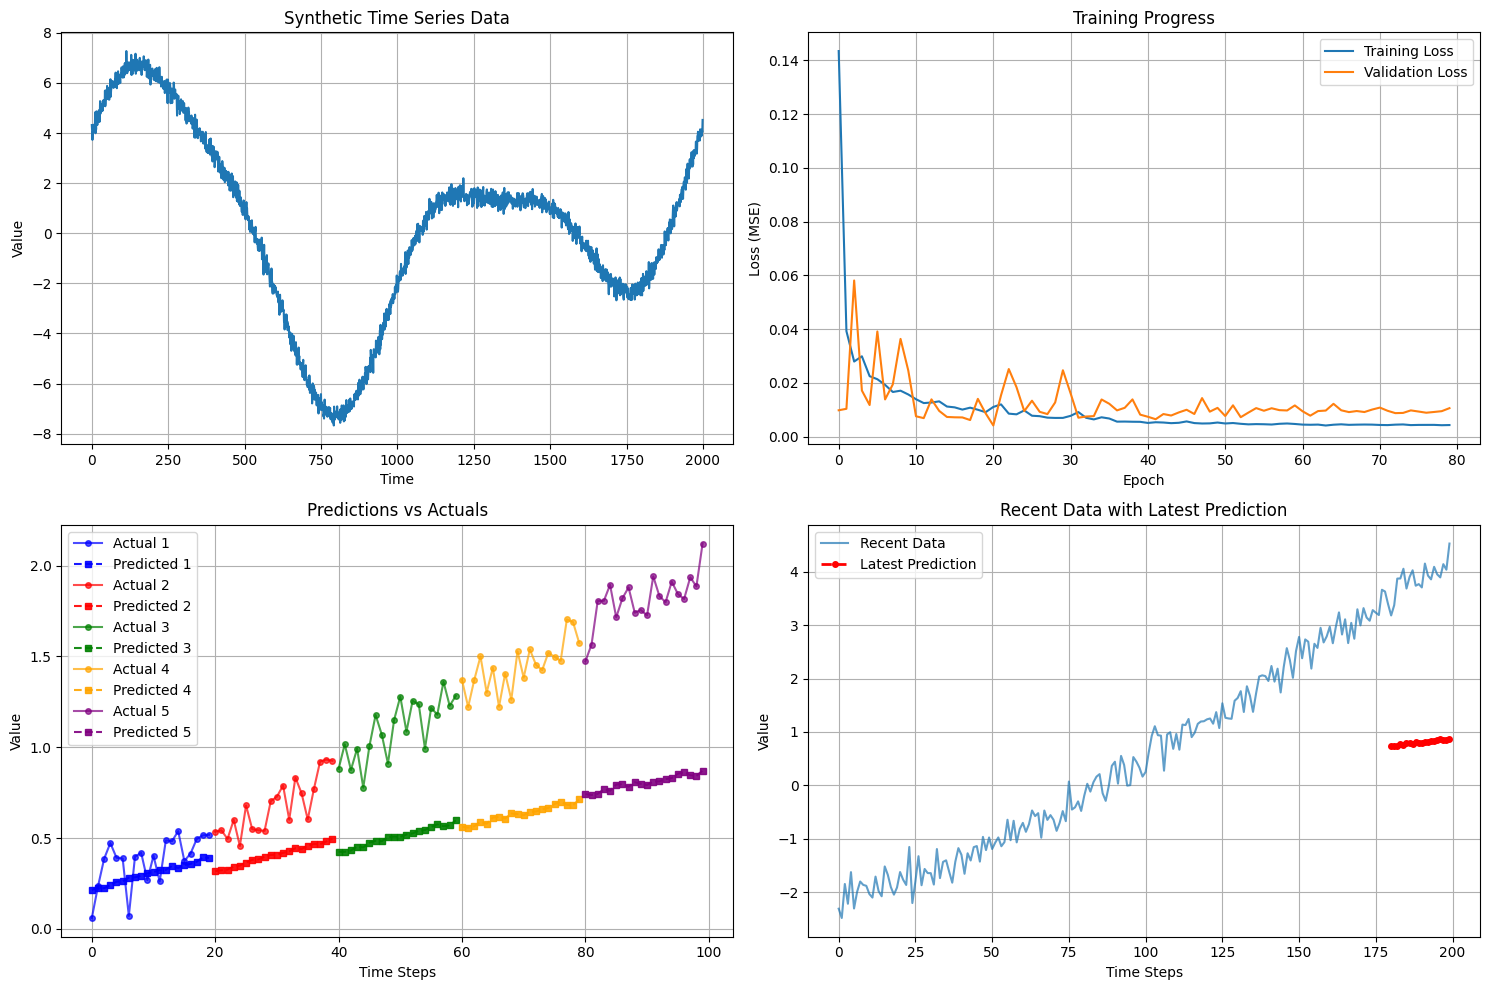


Training and Evaluation Complete!


In [23]:
# Visualize results
print("\nGenerating visualization...")
plot_results(
    data_original,  # Original scale data
    train_losses, 
    val_losses, 
    predictions_denorm,  # Denormalized predictions
    actuals_denorm,      # Denormalized actuals
    seq_length, 
    pred_length
)

print("\n" + "="*60)
print("Training and Evaluation Complete!")
print("="*60)

### 7.2 Visual Results

The plots below show:
1. **Time Series Overview**: Full dataset with train/val/test splits
2. **Training Curves**: Loss evolution during training
3. **Prediction Examples**: Multiple forecasts vs actual values

**How to interpret the predictions:**
- **Blue line**: Actual future values (ground truth)
- **Orange line**: Model's predictions
- **Good fit**: Lines overlap closely
- **Look for**: 
  - Does the model capture trends?
  - Does it handle sudden changes?
  - Are errors systematic (bias) or random?

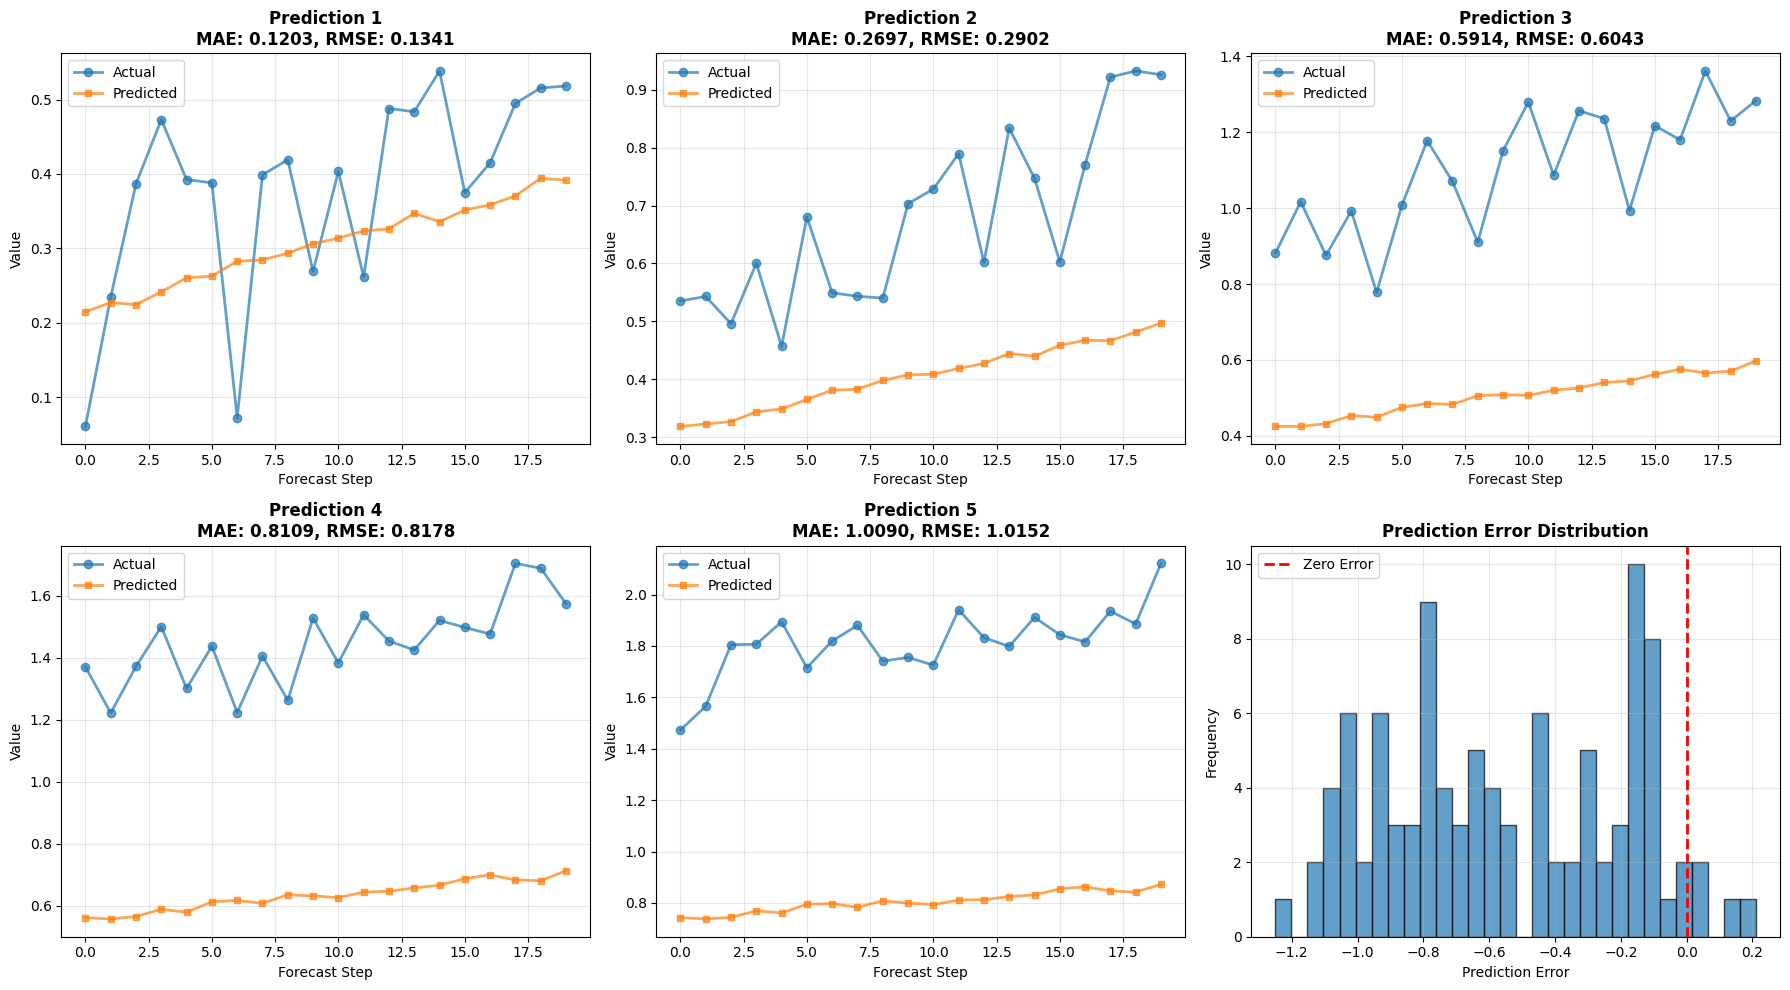


Error Statistics:
  Mean error (bias):     -0.551014
  Std of errors:         0.360200
  Min error:             -1.249714
  Max error:             0.210713

⚠️  Model shows negative bias


In [24]:
# Detailed analysis of predictions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i in range(min(num_test_predictions, 5)):
    ax = axes[i]
    
    # Plot actual vs predicted
    steps = np.arange(pred_length)
    ax.plot(steps, actuals_denorm[i], 'o-', label='Actual', linewidth=2, markersize=6, alpha=0.7)
    ax.plot(steps, predictions_denorm[i], 's-', label='Predicted', linewidth=2, markersize=5, alpha=0.7)
    
    # Calculate metrics for this prediction
    error = predictions_denorm[i] - actuals_denorm[i]
    mae_i = np.mean(np.abs(error))
    rmse_i = np.sqrt(np.mean(error**2))
    
    ax.set_title(f'Prediction {i+1}\nMAE: {mae_i:.4f}, RMSE: {rmse_i:.4f}', fontweight='bold')
    ax.set_xlabel('Forecast Step')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Error distribution plot
ax = axes[5]
all_errors = np.concatenate([predictions_denorm[i] - actuals_denorm[i] for i in range(len(predictions_denorm))])
ax.hist(all_errors, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.set_title('Prediction Error Distribution', fontweight='bold')
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nError Statistics:")
print(f"  Mean error (bias):     {np.mean(all_errors):.6f}")
print(f"  Std of errors:         {np.std(all_errors):.6f}")
print(f"  Min error:             {np.min(all_errors):.6f}")
print(f"  Max error:             {np.max(all_errors):.6f}")

if abs(np.mean(all_errors)) < 0.1:
    print("\n✓ Model is unbiased (mean error ≈ 0)")
else:
    print(f"\n⚠️  Model shows {'positive' if np.mean(all_errors) > 0 else 'negative'} bias")

---

## 8. Understanding Model Predictions

### 8.1 Analyzing Forecast Quality

Let's dive deeper into individual predictions to understand what the model learned:

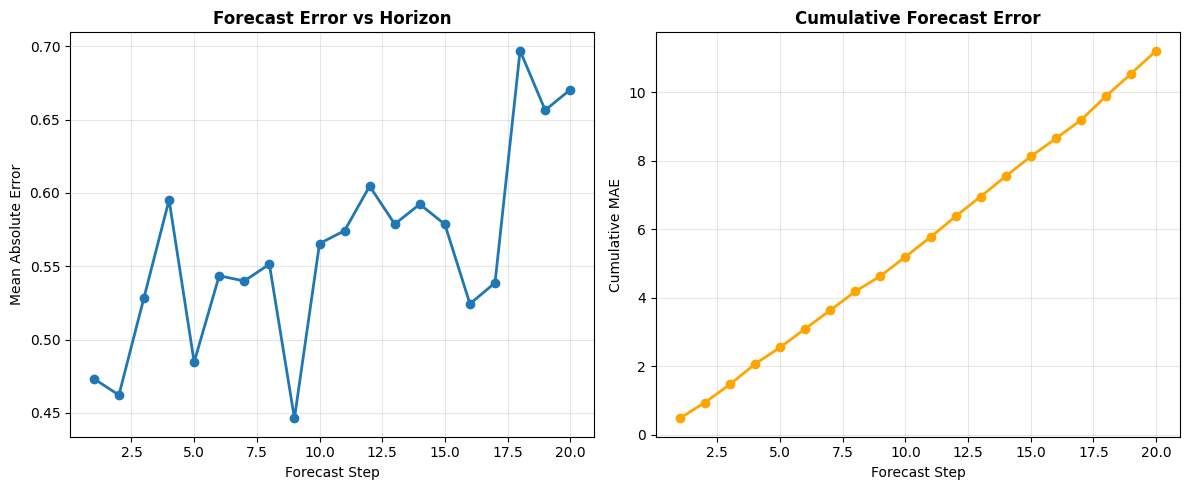


Forecast Horizon Analysis:
  1-step ahead MAE:  0.473302
  10-step ahead MAE: 0.565454
  20-step ahead MAE: 0.670367

Error growth rate: 1.42x


In [25]:
# Analyze error vs forecast horizon
horizon_errors = np.zeros(pred_length)

for step in range(pred_length):
    step_errors = [abs(predictions_denorm[i][step] - actuals_denorm[i][step]) 
                   for i in range(len(predictions_denorm))]
    horizon_errors[step] = np.mean(step_errors)

plt.figure(figsize=(12, 5))

# Plot 1: MAE by forecast step
plt.subplot(1, 2, 1)
plt.plot(range(1, pred_length + 1), horizon_errors, 'o-', linewidth=2, markersize=6)
plt.xlabel('Forecast Step')
plt.ylabel('Mean Absolute Error')
plt.title('Forecast Error vs Horizon', fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 2: Cumulative error
plt.subplot(1, 2, 2)
plt.plot(range(1, pred_length + 1), np.cumsum(horizon_errors), 'o-', linewidth=2, markersize=6, color='orange')
plt.xlabel('Forecast Step')
plt.ylabel('Cumulative MAE')
plt.title('Cumulative Forecast Error', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nForecast Horizon Analysis:")
print(f"  1-step ahead MAE:  {horizon_errors[0]:.6f}")
print(f"  10-step ahead MAE: {horizon_errors[9]:.6f}")
print(f"  20-step ahead MAE: {horizon_errors[19]:.6f}")
print(f"\nError growth rate: {(horizon_errors[19] / horizon_errors[0]):.2f}x")

### 8.2 Forecast Horizon Analysis

How does prediction quality change as we forecast further into the future?

---

## 9. Key Takeaways and Next Steps

### 9.1 What We Learned

**Transformers for Time Series:**
- ✓ Self-attention captures long-range dependencies
- ✓ Parallel processing enables efficient training
- ✓ Positional encoding preserves temporal order
- ✓ Multi-head attention learns diverse patterns

**Practical Insights:**
1. **Data Normalization**: Essential for stable training
2. **Temporal Splitting**: Must preserve time order (no random splits!)
3. **Hyperparameter Choices**: 
   - Longer sequences → more context but slower
   - More layers → more capacity but risk overfitting
   - More heads → diverse attention patterns
4. **Evaluation**: Multi-step forecasting gets harder further ahead

### 9.2 Model Strengths and Limitations

**Strengths:**
- Captures complex temporal patterns
- Handles long sequences efficiently
- Multi-step ahead forecasting
- Learns from data without manual feature engineering

**Limitations:**
- Requires substantial training data
- Computational cost (200k+ parameters)
- Black box (hard to interpret which patterns it learned)
- Forecast uncertainty increases with horizon

### 9.3 Extending This Work

**For better performance:**
1. **More data**: Train on longer time series
2. **Feature engineering**: Add technical indicators, volume, volatility
3. **Multivariate**: Include multiple correlated assets
4. **Ensemble**: Combine multiple models
5. **Hyperparameter tuning**: Grid search or Bayesian optimization

**Advanced architectures:**
- **Temporal Fusion Transformer**: Interpretable attention
- **Informer**: Efficient long-sequence forecasting
- **Autoformer**: Decomposition-based transformer
- **PatchTST**: Patch-based representation

**Real-world deployment:**
- Walk-forward validation
- Rolling window retraining
- Uncertainty quantification (prediction intervals)
- Risk management integration

---

## 10. Exercises

**Beginner:**
1. Change `seq_length` to 50 and 200. How does it affect performance?
2. Modify `pred_length` to 10 and 30. What happens to accuracy?
3. Try different `num_layers` (2, 6, 8). When does overfitting occur?

**Intermediate:**
4. Implement early stopping based on validation loss
5. Add dropout regularization and compare results
6. Load real financial data (stocks, crypto) and retrain
7. Compute prediction intervals (confidence bounds)

**Advanced:**
8. Implement attention visualization to see which time steps the model focuses on
9. Add exogenous variables (features beyond the target series)
10. Implement a decoder for autoregressive multi-step forecasting
11. Compare with LSTM, GRU, and temporal convolutional networks

---

## 11. References and Further Reading

**Papers:**
- Vaswani et al. (2017) - "Attention Is All You Need"
- Zhou et al. (2021) - "Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting"
- Lim et al. (2021) - "Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting"
- Wu et al. (2021) - "Autoformer: Decomposition Transformers with Auto-Correlation"

**Libraries:**
- PyTorch Forecasting: https://pytorch-forecasting.readthedocs.io/
- Darts: https://unit8co.github.io/darts/
- GluonTS: https://ts.gluon.ai/

**Tutorials:**
- Time Series Forecasting with Transformers: https://huggingface.co/blog/time-series-transformers
- PyTorch Time Series: https://pytorch.org/tutorials/intermediate/timeseries_transformer.html

---

**End of Notebook**

**Questions? Feedback?**  
This notebook is part of the Deep Learning for Finance course at Baruch MFE.  
Feel free to experiment, break things, and learn!